#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [17]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [18]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [101]:
sp500 = pd.read_csv("/workspaces/codespaces-jupyter/data/SP500_2006_16_data.csv")
sp500# sp500 = pd.read_csv("https://osf.io/h64z2/download")

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82
...,...,...
2606,2016-08-22,2182.64
2607,2016-08-23,2186.90
2608,2016-08-24,2175.44
2609,2016-08-25,2172.47


In [102]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [106]:
#Fractional change between the current and a prior element. Examples below
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

In [103]:
#Fractial change in action
s = pd.Series([90, 91, None, 85])
s.ffill().pct_change()

0         NaN
1    0.011111
2    0.000000
3   -0.065934
dtype: float64

Create date variables (we dont use these though)

In [104]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

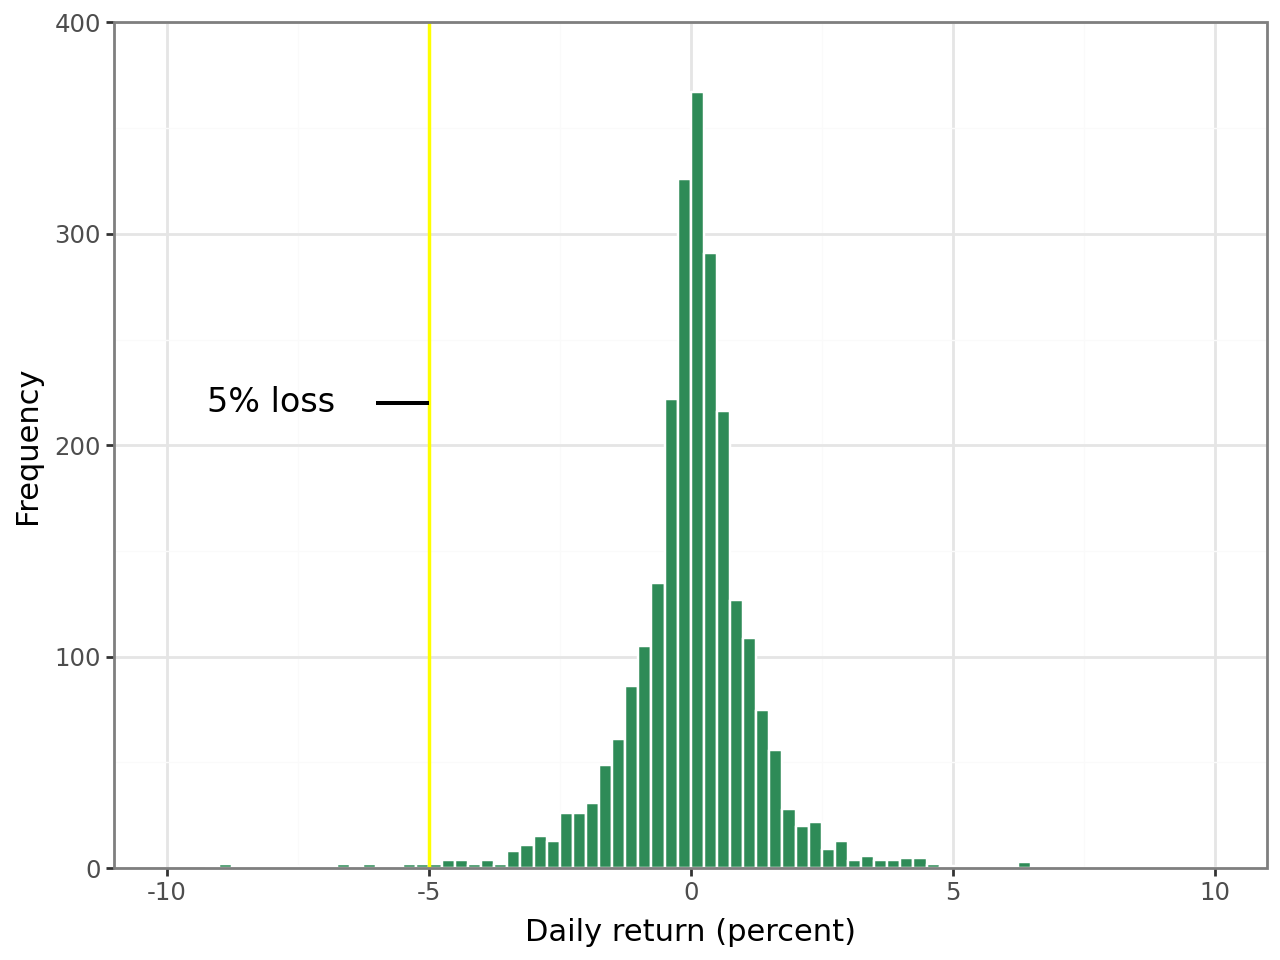

In [108]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill="seagreen", boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color="yellow")
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [139]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

In [109]:
sp500max=sp500.loc[sp500["pct_return"].idxmax()]
sp500max

DATE          2008-10-13 00:00:00
VALUE                     1003.35
year                         2008
month                          10
yearmonth                  200810
pct_return              11.580036
Name: 536, dtype: object

In [157]:
sp500.count()
sp500
sp500less5 = sp500.loc[sp500["pct_return"] < -5].reset_index(drop=True)
sp500less5["pct_return_decimal"] = sp500less5["pct_return"] / 100
sp500less5

,DATE,VALUE,year,month,yearmonth,pct_return,pct_return_decimal
0,2008-09-29,1106.39,2008,9,200809,-8.789705,-0.087897
1,2008-10-07,996.23,2008,10,200810,-5.739481,-0.057395
2,2008-10-09,909.92,2008,10,200810,-7.616708,-0.076167
3,2008-10-15,907.84,2008,10,200810,-9.034980,-0.090350
4,2008-10-22,896.78,2008,10,200810,-6.101251,-0.061013
5,2008-11-05,952.77,2008,11,200811,-5.267711,-0.052677
6,2008-11-06,904.88,2008,11,200811,-5.026397,-0.050264
7,2008-11-12,852.30,2008,11,200811,-5.189388,-0.051894
8,2008-11-19,806.58,2008,11,200811,-6.115560,-0.061156
9,2008-11-20,752.44,2008,11,200811,-6.712291,-0.067123


In [158]:
sp500less5['DATE'].min(), sp500less5['DATE'].max()

(Timestamp('2008-09-29 00:00:00'), Timestamp('2011-08-08 00:00:00'))

In [161]:
sp500less5["pct_return"].mean()

np.float64(-6.65138836502497)

In [155]:
true_share = (sp500["pct_return"] <= -5).mean()
print(true_share)

0.005160778086542279


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [32]:
from importlib import import_module

# Try to import create_sample_frame from the func directory
create_sample = import_module("func_sample")  # replace with actual filename without .py
create_sample_frame = create_sample.create_sample_frame

help(create_sample_frame)

ModuleNotFoundError: No module named 'func_sample'

In [117]:
n_samples = 10000  # Define the number of samples

# For n=1000
samples_1000 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 1000), replace=True)
a=samples_1000 < -5

nobs_1000 = np.mean(samples_1000 < -5, axis=1)

# For n=500
samples_500 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 500), replace=True)
nobs_500 = np.mean(samples_500 < -5, axis=1)


In [118]:
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [134]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000})*100

In [135]:
a = pd.DataFrame(samples_1000).T
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.721960,-1.020249,0.795493,-0.137885,-0.308539,1.754582,0.630279,0.051508,-0.202826,-0.453861,...,-0.095037,0.310587,1.908060,-0.141700,0.137484,-0.093067,-0.700035,-0.026927,-0.971743,0.196708
1,-0.670226,0.900937,2.581761,-1.169385,0.600162,0.248492,1.143155,-0.101054,0.147412,1.288411,...,1.830372,-0.382825,0.072513,0.014979,0.724264,0.225280,-0.527787,-2.078329,-1.187146,-0.453861
2,0.404994,3.428485,0.604051,-6.101251,-0.539549,-0.159267,1.639550,0.615228,-1.504050,-1.374621,...,0.255644,-1.321247,1.666986,-1.874310,0.035060,0.265154,-2.283195,0.317463,0.304503,0.489749
3,0.764113,-0.646342,-0.525643,0.181708,0.698969,-0.116595,4.072862,-0.293268,-0.853140,0.601949,...,0.494808,-0.608458,-1.708146,0.327970,0.488019,1.349206,0.211889,0.807404,-0.479904,-0.179889
4,0.811413,0.437967,0.356357,1.948874,0.746988,1.287301,0.235773,0.619725,-0.768163,1.178346,...,-1.237467,-2.455154,-3.312016,0.545270,-0.116596,-1.105000,0.147098,-0.140442,0.033849,0.523688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.282180,-0.768163,0.356357,0.390712,0.024027,1.336402,-1.779724,0.105109,0.773903,-0.256388,...,0.112823,-1.359792,1.059274,-0.143618,-1.418546,1.094876,0.438642,0.416419,-0.471630,1.223750
996,0.228417,0.523029,-1.530378,-0.692200,-0.307315,0.473457,0.496303,0.367975,0.073980,6.921272,...,0.964311,-0.886378,-1.397983,0.054398,0.884494,0.216028,1.364461,-1.120033,-0.127514,0.509527
997,-2.936978,0.034524,-0.163876,-0.581306,-0.471630,-0.838546,0.703932,-0.688635,0.294077,0.548304,...,0.510676,-0.093053,0.217259,0.018156,-0.156737,-1.181053,-0.809366,-0.197775,0.427206,0.176142
998,-0.305962,-0.443353,2.406903,-0.268551,0.377510,-0.652448,-0.208100,0.544547,-2.278472,0.289984,...,0.798263,2.332039,0.205942,0.420113,0.514829,-0.269053,0.826553,-0.816330,0.030520,-2.311751


In [136]:
nobs_df

,nobs_500,nobs_1000
0,0.2,0.5
1,0.4,1.3
2,0.4,0.6
3,0.4,0.3
4,0.4,0.5
...,...,...
9995,0.0,0.6
9996,0.4,0.5
9997,0.6,0.3
9998,0.0,0.4


In [137]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

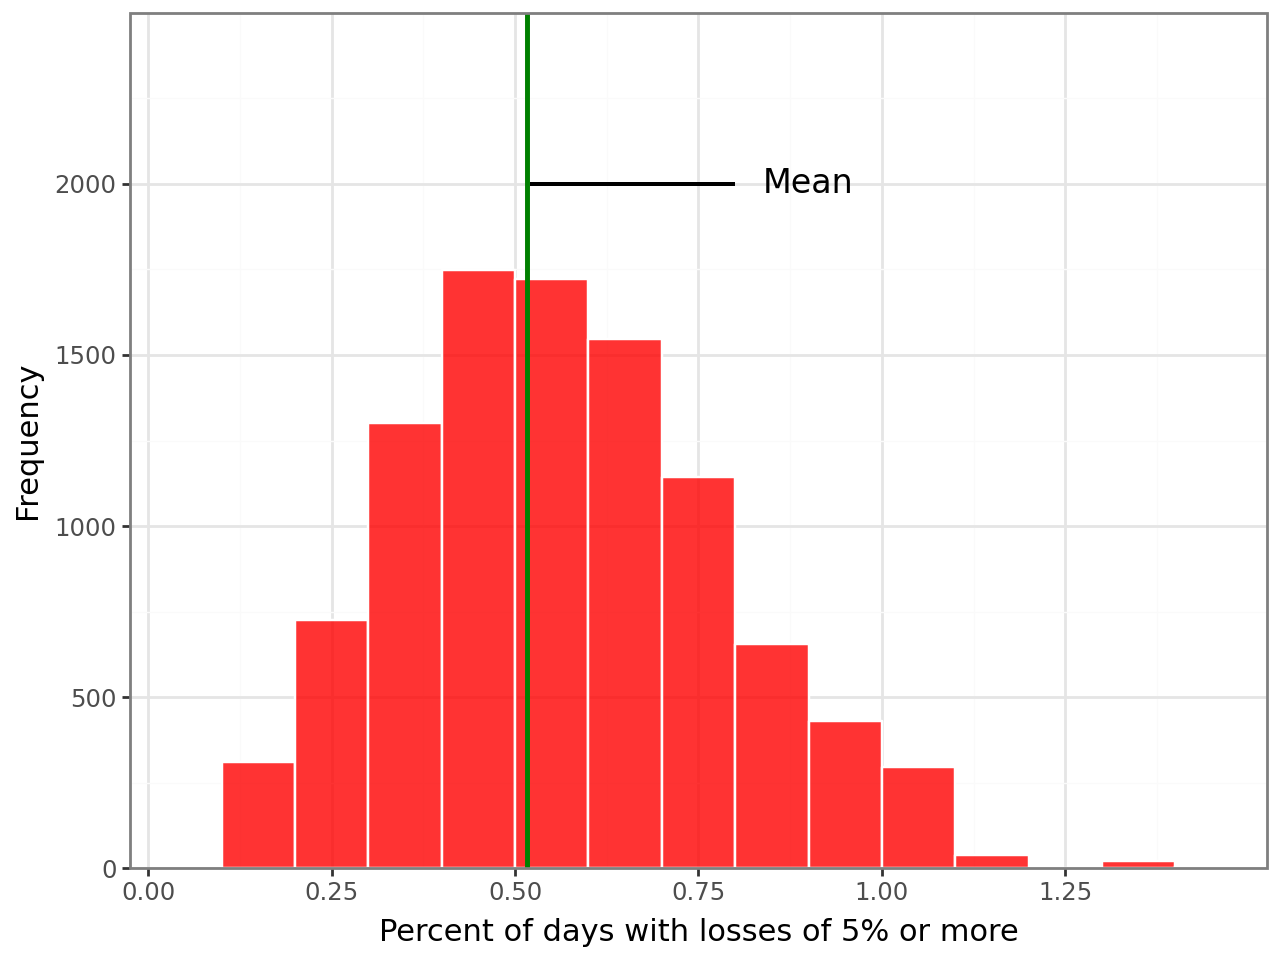

In [138]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill="red",
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color="green", size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=np.arange(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

In [125]:
nobs_df["nobs_1000"].std()

np.float64(0.22595969923543413)

In [140]:
nobs_df["nobs_1000"].mean()

np.float64(0.5160100000000001)

### Figure 5.3 

Not working with epanechnikov kernel

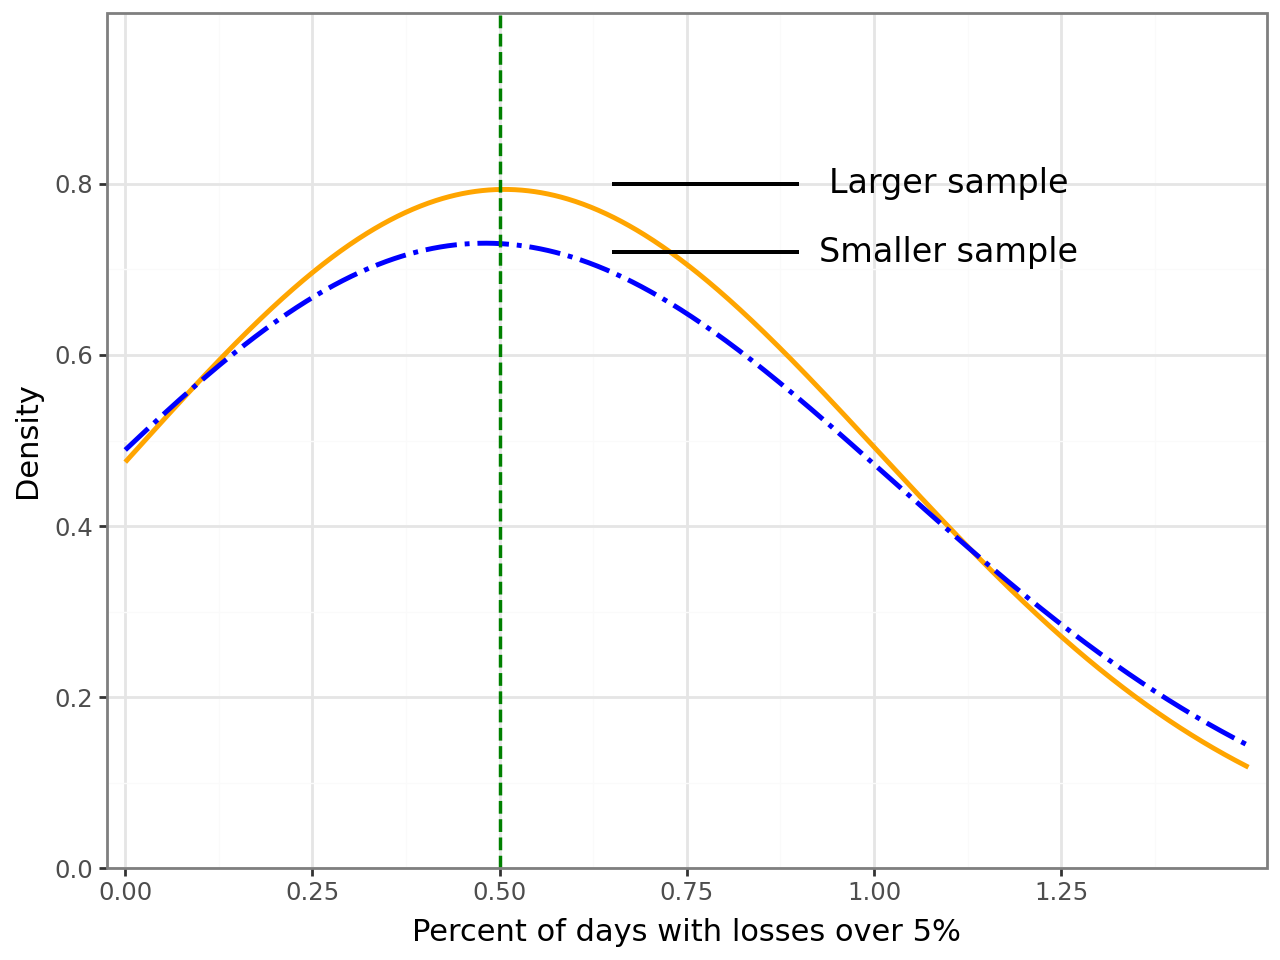

In [127]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color="orange", geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color="blue",
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color="green", size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=np.arange(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

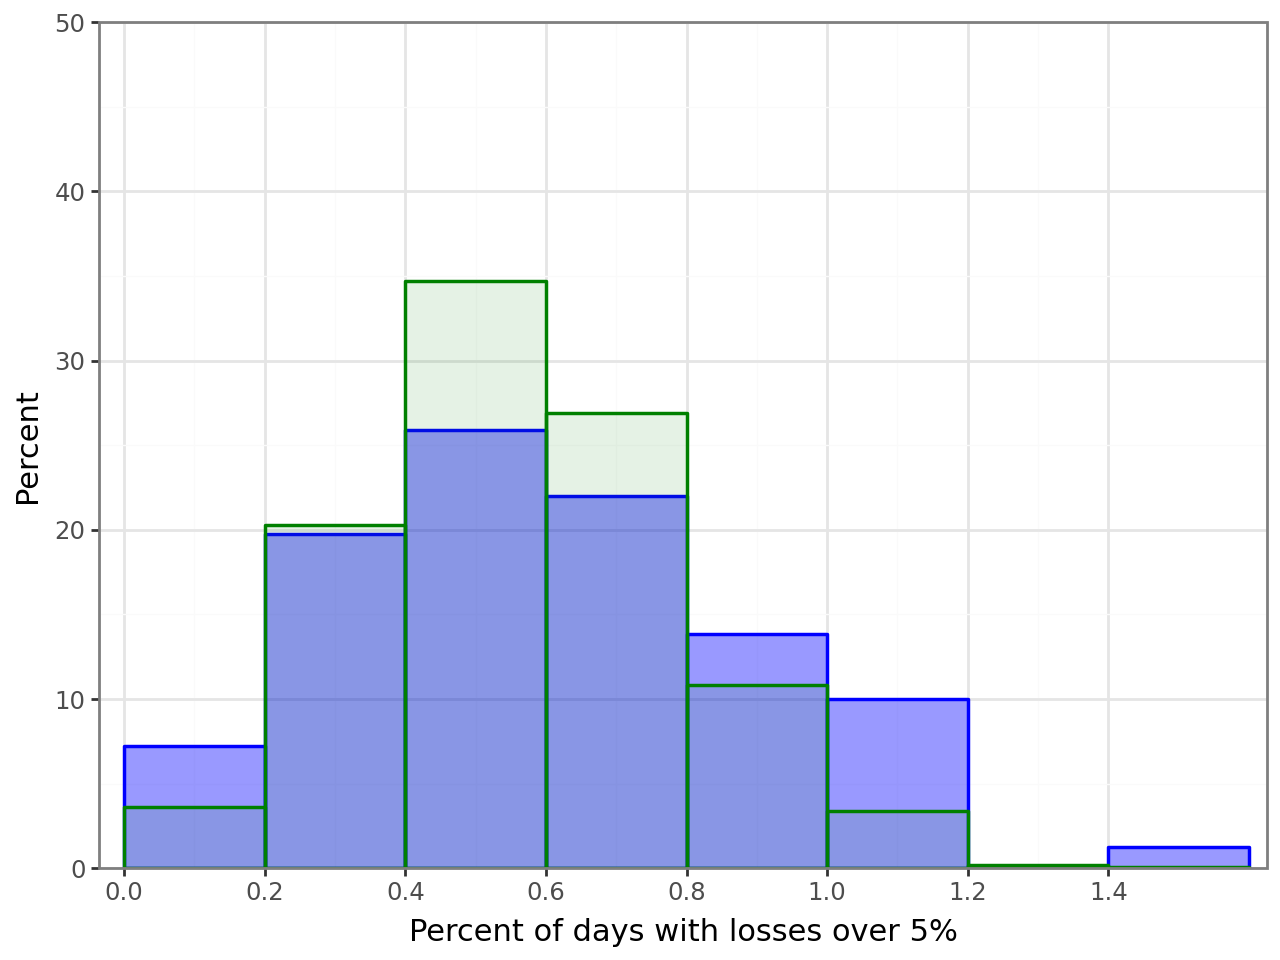

In [144]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color="blue",
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color="green",
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=np.arange(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=("blue", "green")
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [ ]:
bootstrap_samples = create_sample_frame(
    sp500["pct_return"], len(sp500["pct_return"]), with_replacement=True
)

Calculate percent of days wit losses over  thresholds from -1 to 10

In [ ]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

Plot percent of days with losses over -5%

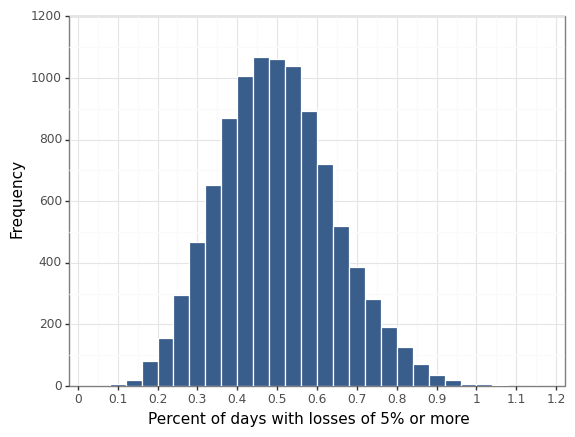

<ggplot: (678354791)>

In [ ]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
